In [1]:
# Redes neurais
import pandas as pd
import numpy as np
import folium
import branca.colormap as cm
import tensorflow as tf
import copy
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

original_data = pd.read_csv('kc_house_data.csv')

# Pré-processamento
original_data = original_data.sample(frac=1)
data = original_data.drop(['id', 'zipcode'], axis=1)
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].apply(lambda date: date.year)
data['month'] = data['date'].apply(lambda date: date.month)
data = data.drop('date', axis=1)
data = data.dropna()

X = data.drop('price', axis=1).values
y = data['price'].values

2023-07-20 12:52:05.703750: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Treinamento
kf = KFold(n_splits=3, shuffle=True)
layers_sequences = [[32, 64, 32]]
input_size = X.shape[1]
best_loss = float('inf')
best_model, best_X_train, best_y_train, best_X_test, best_y_test = None, None, None, None, None

# Iteração dos hiperparâmetros
for layer_sequence in layers_sequences:
    # Montagem do modelo
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(input_size, activation='linear', input_shape=(input_size,)))
    for num_neurons in layer_sequence:
        model.add(tf.keras.layers.Dense(num_neurons, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='adam', loss='mse')

    losses = list()
    # Iteração dos folds
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index] 
        y_train, y_test = y[train_index], y[test_index]
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(X_train, y_train, epochs=1000, verbose=0, batch_size=200)
        loss = model.evaluate(X_test, y_test, verbose=0)
        losses.append(loss)
        print(f'Fold {fold+1}, {layer_sequence}, loss: {loss}')
        if loss < best_loss:
            best_loss = loss
            best_model = copy.deepcopy(model)
            best_train_idx = train_index
            best_test_idx = test_index
            best_layer_sequence = layer_sequence
            best_scaler = scaler
    print(f'Média: {np.mean(losses)} ± {np.std(losses)}')
print(best_layer_sequence)

Fold 1, [32, 64, 32], loss: 21753538560.0
Fold 2, [32, 64, 32], loss: 16310219776.0
Fold 3, [32, 64, 32], loss: 17578096640.0
Média: 18547284992.0 ± 2325499859.1415663
[32, 64, 32]


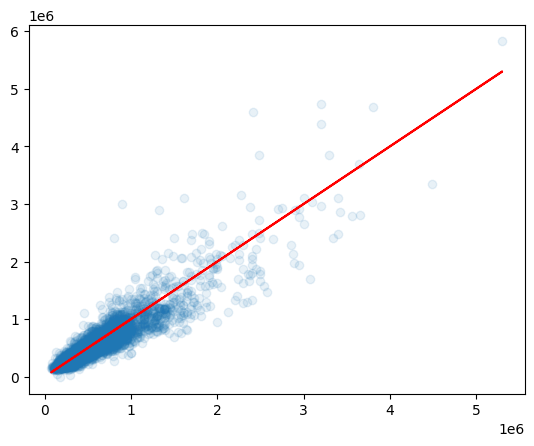

In [3]:
import matplotlib.pyplot as plt
test_pred = best_model.predict(X_test, verbose=0)
plt.scatter(y_test, test_pred, alpha=.1)
plt.plot(y_test,y_test, 'r')

In [4]:
# Variáveis
X_normalized = best_scaler.transform(X)
predictions = best_model.predict(X_normalized, verbose=0)
new_data = data.copy()
new_data['is_test'] = [idx in best_test_idx for idx, _ in new_data.iterrows()]
new_data['prediction'] = predictions
new_data['erro'] = [1-loc['prediction']/loc['price'] for i, loc in new_data.iterrows()]


In [ ]:
# Mapas
lim_pontos = float('inf')
num_pontos = min(new_data.shape[0], lim_pontos)
lat_ini = np.mean([new_data.lat.min(),new_data.lat.max()])
long_ini = np.mean([new_data.long.min(),new_data.long.max()])

mapObj = folium.Map(location=[lat_ini,long_ini], max_zoom=15, min_zoom=5)
cont = 0
colormap = cm.LinearColormap(colors=['green', 'white', 'red'], index=[-1, 0, 1], vmin=-1, vmax=1)

for i, loc in new_data.iterrows():
    cont += 1
    if cont > num_pontos:
        break
    if loc.is_test:
        popup = str()
        for col, value in loc.items():
            popup += f"\t{col}: {value}<br>"
        tip = f'''Price: ${loc.price} <br> 
                Predicted: ${loc.prediction:.2f} <br> 
                Erro: {loc.erro*100:.4f}%'''
        folium.CircleMarker(location=[loc.lat,loc.long],radius=3, fill=True, fill_opacity=1, tooltip = tip,
                            fill_color=colormap(loc['erro']), weight=1, color='black', popup=popup).add_to(mapObj)

mapObj.save('output.html')